<a href="https://colab.research.google.com/github/martin-embryo/colab/blob/master/Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Metrics Notebook

In [ ]:
from datetime import datetime
import sanity_tests
import sys
import csv
import os
import math
import cv2
import h5py
import glob
import numpy as np
import pandas as pd
from pandas import read_csv
import tensorflow as tf
from tensorflow.python.client import device_lib
from pandas import read_csv

import tensorflow
from tensorflow.image import grayscale_to_rgb
from tensorflow.image import resize_images
import tensorflow.keras as keras_tf
import keras as keras_na

from importance_sampling.training import ImportanceTraining

#keras_type = 'tensorflow'
keras_type = 'native'

if keras_type == 'native':
    import keras
    from keras.applications import inception_resnet_v2
    from keras.applications import vgg19

    from keras.models import Sequential, Model
    from keras.models import load_model

    from keras.layers import Input
    from keras.layers import Conv1D, Dense, Conv2D, Flatten, Dropout
    from keras.layers import TimeDistributed, ConvLSTM2D
    from keras.layers import AveragePooling2D, MaxPooling2D, MaxPooling1D, AveragePooling1D, MaxPooling3D
    from keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, GlobalMaxPooling2D
    from keras.layers import LSTM
    from keras.layers import Lambda
    from keras.layers import Concatenate, concatenate
    from keras.layers.core import Reshape

    from keras.optimizers import Adadelta
    from keras.optimizers import RMSprop
    from keras.optimizers import Adam

    from keras.regularizers import l1
    
    from keras.utils import plot_model

    from keras import backend as K
    #from keras.preprocessing import sequence
    #from keras.backend import squeeze
    
    from keras.callbacks import EarlyStopping
    from keras.callbacks import TensorBoard
    from keras.callbacks import ReduceLROnPlateau

elif keras_type == 'tensorflow':
    import tensorflow.keras as keras
    from tensorflow.keras.applications import inception_resnet_v2
    from tensorflow.keras.applications import vgg19
    
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.models import load_model

    from tensorflow.keras.layers import Input
    from tensorflow.keras.layers import Conv1D, Dense, Conv2D, Flatten, Dropout
    from tensorflow.keras.layers import TimeDistributed, ConvLSTM2D
    from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, MaxPooling1D, AveragePooling1D, MaxPooling3D
    from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, GlobalMaxPooling2D
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Lambda
    from tensorflow.keras.layers import Concatenate, concatenate
    from tensorflow.keras.layers.core import Reshape

    from tensorflow.keras.optimizers import Adadelta
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras.optimizers import Adam

    from tensorflow.keras.regularizers import l1
    
    from tensorflow.keras.utils import plot_model

    from tensorflow.keras import backend as K
    from tensorflow.keras.backend import squeeze
    #from tensorflow.keras.preprocessing import sequence
    
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import TensorBoard
    from tensorflow.keras.callbacks import ReduceLROnPlateau
    
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl

from google.cloud import storage

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, recall_score, precision_score, jaccard_similarity_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import linkage

K.image_data_format = 'channels_last' #Height-Width-Depth

project_id    = 'keen-incline-232408'
bucket_name   = 'embryonicsbucket'
model_dir  = './Models/'
data_dir   = './Data/'

storage_client = storage.Client(project = project_id)
bucket = storage_client.get_bucket(bucket_name)

In [121]:
# this function loads a standard dataset, constructed so as to train a particular model, and the model+weight files associated with the run.

# the function outputs a dataframe which includes the relevant fields from the dataset, which include:
# the unique identifier of each embryo ('name' + 'well' = 'uniq'), the implantation binary marker for each embryo ('implant').
# a model prediction, based on loaded model, for each embro ('pred').
# other output fields are grades, normalized to [0..1] (binary or prediction)
# however you can optionally also output the binary\probablity input as grades (1-5)

def dataset_to_dataframe(dataset_file, model_file, weights_file, model_type = 'S', filter_ground_truth = True, include_grades = False, log = False):
    def score_to_probability(x):
        return ((float(x)-1)/4)
    def probability_to_score(x):
        return ((float(x)*4)+1)
    
    include_predictions = True
    columns = ['uniq', 'name', 'well', 'implant', 'pred', 'p_olga', 'p_natali']
    if include_grades: columns += ['g_olga', 'g_natali', 'g_pred', 'g_implant']
    names = []
    
    if log: start_time = datetime.now()
    with h5py.File(dataset_file) as h5:
        df = pd.DataFrame(columns = columns)
        for k, fold in enumerate(h5.keys()):
            if 'fold' in fold:
                tf.reset_default_graph()
                K.set_session(tf.get_default_session())
                K.clear_session() 

                model = load_model(model_file)
                model.load_weights(weights_file.format(k+1))
                df2 = pd.DataFrame(columns = columns)
                validate = h5[fold]['validate']
                df2['well'] = map(int, validate['well'])
                df2['name'] = map(str, validate['patient'])
                df2['uniq'] = df2[['name', 'well']].apply(lambda x: x[0] + '_W' + str(x[1]), axis=1)
                
                if (model_type == 'P'):
                    results = model.predict(validate['X'])[:,1]
                elif (model_type == 'S'):
                    results = map(score_to_probability, model.predict(validate['X']))
                else:
                    results = np.empty(validate['well'].shape[0])
                    results.fill(np.nan)
                    print 'error! unknown model type', mode_type
                    
                if include_predictions:
                    df2['implant'] = validate['implant'][:,1]
                    df2['pred'] = results
                    df2['p_natali'] = map(score_to_probability, validate['grade'][:,0])
                    df2['p_olga'] = map(score_to_probability, validate['grade'][:,1])
                if include_grades:
                    df2['g_natali'] = map(float, validate['grade'][:,0])
                    df2['g_olga'] = map(float, validate['grade'][:,1])
                    df2['g_implant'] = map(probability_to_score, validate['implant'][:,1])
                    df2['g_pred'] = map(probability_to_score, results)
                    if log: print int(np.nansum(df2['g_natali'])), len(validate['grade'][:,0])
                names += list(df2['name'].unique())
                df = df.append(df2)
                
        df = df.sort_values(by = ['name', 'well'])
        df = df.set_index('uniq')
        #df = df.reset_index(inplace = False, drop = True)
        if (sorted(list(set(names))) != sorted(names)): 
            print 'error! contamination in patient names!'
            if log: print sorted(names)
    if filter_ground_truth:
        df = df[~df['implant'].isnull()]
    if log: print datetime.now() - start_time
    return df

In [136]:
# this function takes in a grade-score (1-5) and generates statistics over the score, 
# in light of the ground truth

# there is a two-step decision, to determine over the decision of any single embryo:
# 1) whether an embryo's predicted grade is over the minimum threshold for implantation. 
# 2) whether the embryo is in the top-k embryos selected for implantation AND was successfully implanted.

def metrics_at_k(df, k, pred_col, thresh = 0.5, log = False):
    def cutoff_probability(x, thresh):
        if np.isnan(x):
            return np.nan
        elif (x > thresh):
            return 1
        else:
            return 0
    metrics_list = ['recall', 'precision', 'accuracy', 'fpr']
    metrics, mean_metrics, metric_count = {}, {}, {}
    for metric in metrics_list:
        metrics[metric] = []
        mean_metrics[metric] = 0.0
        metric_count[metric] = 0
    df = df.reset_index()
    names = df['name'].unique()
    pk_list = []
    for name in names: #iterate over each specific patient
        df_name = df[(df['name'] == name) & ~df[pred_col].isnull()]
        n_embryos = df_name.shape[0]
        if n_embryos < k:
            if log: print 'excluded', name, n_embryos
            continue
        else:
            if log: print 'included', name, n_embryos
            tp, fp, tn, fn = 0, 0, 0, 0
            df_name = df_name.sort_values(by = ['implant', pred_col], ascending = False)
            if log: print df_name
            for i in range(min(k, n_embryos)):
                real = df_name.iloc[i]['implant']
                pred = cutoff_probability(df_name.iloc[i][pred_col], thresh)
                if (real == 1):
                    if   (pred == 1): tp += 1.0
                    elif (pred == 0): fn += 1.0
                elif (real == 0):
                    if   (pred == 0): tn += 1.0
                    elif (pred == 1): fp += 1.0
            accuracy_k = (tp+tn) / (tp+tn+fp+fn)
            if log: print 'accuracy:', accuracy_k, 'tp,fp,tn,fn:', tp, fp, tn, fn
            metrics['accuracy'].append(accuracy_k)
            if ((fn > 0) or (tp > 0)):
                recall_k = tp/(tp+fn)
                metrics['recall'].append(recall_k)
                if log: print 'recall:', recall_k
            if ((tp > 0) or (fp > 0)):
                precision_k = tp/(tp+fp)
                metrics['precision'].append(precision_k)
                if log: print 'precision:', precision_k
            if ((fp > 0) or (tn > 0)):
                fpr_k = fp/(fp+tn)
                metrics['fpr'].append(fpr_k)
                if log: print 'precision:', precision_k
    for metric in metrics_list:
        mean_metrics[metric] = np.mean(metrics[metric])
        metric_count[metric] = len(metrics[metric])
    return metrics, mean_metrics, metric_count

Create a Dataframe with Model predictions and relevent data (embry and implantation info)

In [131]:
model_file   = './Models/model_s_ukraine_resnet_repo_2019-06-03_01_k10.h5'
weights_file = './Models/weights_s_ukraine_resnet_repo_2019-06-03_01_k{}of10.h5'
dataset_file = './Data/dataset_ukraine_resnet_repo_2019-05-28_20_k10.h5'
predict_file = './ukraine_model_result_df_2019-06-03_01_k10.csv'

df = dataset_to_dataframe(dataset_file, model_file, weights_file, model_type = 'S')
df.to_csv(predict_file)

Load Dataframe and calculate metrices

In [132]:
predict_file = './ukraine_model_result_df_2019-06-03_01_k10.csv'
df = read_csv(predict_file)
df.head()

,uniq,name,well,implant,pred,p_olga,p_natali
0,S0074_W1,S0074,1,1.0,0.171587,NaN,0.75
1,S0074_W8,S0074,8,0.0,0.393375,NaN,0.75
2,S0074_W9,S0074,9,0.0,0.254416,NaN,0.75
3,S0087_W6,S0087,6,0.0,0.544513,NaN,1.00
4,S0104_W4,S0104,4,1.0,0.122851,0.75,NaN


In [137]:
for k in range(1,4):
    print 'metrics @ k =', k
    for metric in ['implant', 'p_natali', 'p_olga', 'pred']:
        print metric, 'metric:', metrics_at_k(df, k, metric, log = False)[1], ', count:', metrics_at_k(df, k, metric)[2]

metrics @ k = 1
implant metric: {'recall': 1.0, 'fpr': 0.0, 'precision': 1.0, 'accuracy': 1.0} , count: {'recall': 266, 'fpr': 36, 'precision': 266, 'accuracy': 302}
p_natali metric: {'recall': 0.75, 'fpr': 0.9230769230769231, 'precision': 0.5294117647058824, 'accuracy': 0.46774193548387094} , count: {'recall': 36, 'fpr': 26, 'precision': 51, 'accuracy': 62}
p_olga metric: {'recall': 0.7692307692307693, 'fpr': 0.7272727272727273, 'precision': 0.7142857142857143, 'accuracy': 0.6216216216216216} , count: {'recall': 26, 'fpr': 11, 'precision': 28, 'accuracy': 37}
pred metric: {'recall': 0.7631578947368421, 'fpr': 0.5833333333333334, 'precision': 0.90625, 'accuracy': 0.7218543046357616} , count: {'recall': 266, 'fpr': 36, 'precision': 224, 'accuracy': 302}
metrics @ k = 2
implant metric: {'recall': 1.0, 'fpr': 0.0, 'precision': 1.0, 'accuracy': 1.0} , count: {'recall': 39, 'fpr': 23, 'precision': 39, 'accuracy': 60}
p_natali metric: {'recall': 0.6666666666666666, 'fpr': 0.8333333333333334,

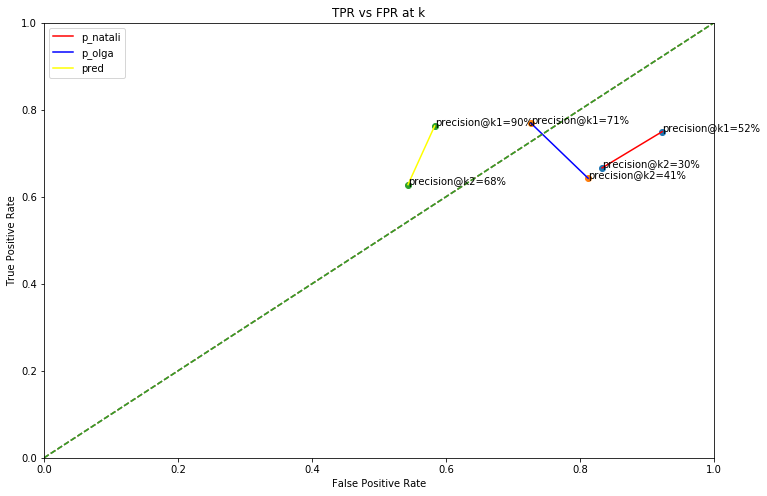

In [151]:
colors = ['red', 'blue', 'yellow']
column = ['p_natali', 'p_olga', 'pred']

plt.figure(figsize = (12,8))
plt.title('TPR vs FPR at k')
for (metric, color) in zip(column, colors):
    fpr, tpr = [], []
    #for k in range(1,4):
    for k in range(1,3):
        fpr.append(metrics_at_k(df, k, metric)[1]['fpr'])
        tpr.append(metrics_at_k(df, k, metric)[1]['recall'])
        plt.annotate('precision@k{}={}%'.format(k, int(metrics_at_k(df, k, metric)[1]['precision']*100)), (fpr[-1], tpr[-1]))
    plt.plot(fpr, tpr, label = metric, color = color)
    plt.scatter(fpr, tpr)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1],[0,1], '--')
    plt.legend()

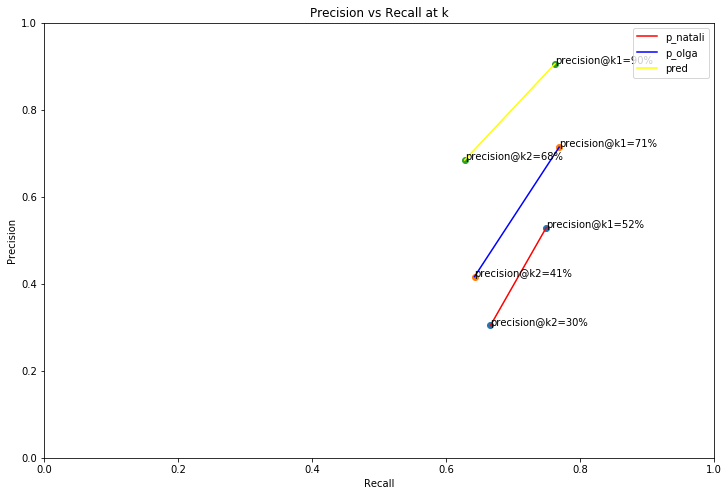

In [150]:
colors = ['red', 'blue', 'yellow']
column = ['p_natali', 'p_olga', 'pred']

plt.figure(figsize = (12,8))
plt.title('Precision vs Recall at k')
for (metric, color) in zip(column, colors):
    precision, recall = [], []
    #for k in range(1,4):
    for k in range(1,3):
        precision.append(metrics_at_k(df, k, metric)[1]['precision'])
        recall.append(metrics_at_k(df, k, metric)[1]['recall'])
        plt.annotate('precision@k{}={}%'.format(k, int(metrics_at_k(df, k, metric)[1]['precision']*100)), (recall[-1], precision[-1]))
    plt.plot(recall, precision, label = metric, color = color)
    plt.scatter(recall, precision)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()